# Summary

# Imports

In [ ]:
import concurrent.futures
import itertools
import importlib
import multiprocessing
import os
import os.path as op
import pickle
import subprocess
import sys
import tempfile
from functools import partial
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import sqlalchemy as sa
from scipy import stats

from kmtools import py_tools, sequence_tools

In [ ]:
%matplotlib inline

In [ ]:
pd.set_option("max_columns", 100)

In [ ]:
SRC_PATH = Path.cwd().joinpath('..', 'src').resolve(strict=True)

if SRC_PATH.as_posix() not in sys.path:
    sys.path.insert(0, SRC_PATH.as_posix())
    
import helper
importlib.reload(helper)

# Parameters

In [ ]:
NOTEBOOK_PATH = Path('validation_homology_models')
NOTEBOOK_PATH

In [ ]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH

In [ ]:
proc = subprocess.run(["git", "rev-parse", "--short", "HEAD"], stdout=subprocess.PIPE)
GIT_REV = proc.stdout.decode().strip()
GIT_REV

In [ ]:
TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")
NETWORK_NAME = os.getenv("NETWORK_NAME", GIT_REV)

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None

TASK_ID, TASK_COUNT

In [ ]:
DEBUG = "CI" not in os.environ    
DEBUG

In [ ]:
if DEBUG:
    NETWORK_NAME = "dcn_old_0,9c5a963"
else:
    assert NETWORK_NAME is not None
    
NETWORK_NAME

In [ ]:
# if DEBUG:
#     %load_ext autoreload
#     %autoreload 2

# `DATAPKG`

In [ ]:
DATAPKG = {}

In [ ]:
DATAPKG['uniparc-domain-wstructure'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("uniparc-domain-wstructure", "master")
)

In [ ]:
DATAPKG['adjacency_net_v2'] = (
    Path(os.environ['DATAPKG_OUTPUT_DIR'])
    .joinpath("adjacency_net_v2", "master")
)

In [ ]:
DATAPKG['hhsuite-wstructure'] = {
    'pdb_homology_modeling': 
        Path(os.environ['DATAPKG_OUTPUT_DIR']).joinpath(
            "hhsuite-wstructure",
            "master",
            "pdb_homology_modeling",
        ),
    'pdb_homology_modeling_adjacency_matrix': 
        Path(os.environ['DATAPKG_OUTPUT_DIR']).joinpath(
            "hhsuite-wstructure",
#             "master",
#             "354abf6aa8a49dded9955be5580bde4d6ac10c60",
            "e062231f4490081db273d21ec832acb18f36bcbb",
            "pdb_homology_modeling_adjacency_matrix",
        ),
    'pdb_homology_modeling_rosetta_score':  
        Path(os.environ['DATAPKG_OUTPUT_DIR']).joinpath(
            "hhsuite-wstructure",
#             "master",
            "09ae1a7157c6c98e8b7bdd93b0e7e6d4cf7587fc",
            "pdb_homology_modeling_rosetta_score",
        ),
}

# Load data

## Read Parquet files

### `pdb_homology_modeling`

In [ ]:
homology_model_files = (
    sorted(DATAPKG['hhsuite-wstructure']['pdb_homology_modeling'].glob('*-?.parquet')) +
    sorted(DATAPKG['hhsuite-wstructure']['pdb_homology_modeling'].glob('*-??.parquet'))    
)

assert len(homology_model_files) == 10
homology_model_files[:2]

In [ ]:
columns = [
    "unique_id", "query_id",

    "dope_score", "ga341_score", "dope_score_norm", "molpdf",
    
    "identity_calc", "coverage_calc",

    "score", "similarity", "sum_probs",
    "evalue", "probability", "identity",

    "query_ali", "template_ali",
    "query_match_length", "template_match_length",
    
    "sequence",
    'hm_residue_idx_1', 'hm_residue_idx_2',
    "adjacency_idx_1_from_pdb", "adjacency_idx_2_from_pdb", 
    "adjacency_idx_1_from_hm", "adjacency_idx_2_from_hm",
]

pdb_homology_modeling = (
    pq.ParquetDataset(homology_model_files)
    .read_pandas(columns=columns)
    .to_pandas()
)

In [ ]:
display(pdb_homology_modeling.head(1))
print(len(pdb_homology_modeling))

### `pdb_homology_modeling_adjacency_matrix`

In [19]:
pdb_homology_modeling_adjacency_matrix_files = sorted(
    DATAPKG
    ['hhsuite-wstructure']
    ['pdb_homology_modeling_adjacency_matrix']
    .glob('*-???.parquet')
)

assert len(pdb_homology_modeling_adjacency_matrix_files) == 10
pdb_homology_modeling_adjacency_matrix_files[:2]

In [20]:
dfs = []
for file in pdb_homology_modeling_adjacency_matrix_files:
    df = pq.read_table(file, columns=columns, use_pandas_metadata=True).to_pandas()
    dfs.append(df)
    

pdb_homology_modeling_adjacency_matrix = pd.concat(dfs)

In [21]:
# pdb_homology_modeling_adjacency_matrix = (
#     pq.ParquetDataset(pdb_homology_modeling_adjacency_matrix_files)
#     .read_pandas()
#     .to_pandas()
# )

In [22]:
display(pdb_homology_modeling_adjacency_matrix.head(1))
print(len(pdb_homology_modeling_adjacency_matrix))

### `pdb_homology_modeling_rosetta_score`

In [23]:
files = sorted(
    DATAPKG
    ['hhsuite-wstructure']
    ['pdb_homology_modeling_rosetta_score']
    .glob('*-???-?.parquet')
)

len(files)

In [24]:
pdb_homology_modeling_rosetta_score = (
    pq.ParquetDataset(files)
    .read_pandas()
    .to_pandas()
)

In [25]:
display(pdb_homology_modeling_rosetta_score.head(1))
print(len(pdb_homology_modeling_rosetta_score))

## Combine into a single dataset

### `homology_models_dataset`

In [26]:
homology_models_dataset = (
    pdb_homology_modeling
    .merge(pdb_homology_modeling_adjacency_matrix, left_index=True, right_index=True, suffixes=("", "_2"))
    .merge(pdb_homology_modeling_rosetta_score, left_index=True, right_index=True, suffixes=("", "_3"))
)

assert (homology_models_dataset['unique_id'] == homology_models_dataset['unique_id_2']).all()
del homology_models_dataset['unique_id_2']

assert (homology_models_dataset['unique_id'] == homology_models_dataset['unique_id_3']).all()
del homology_models_dataset['unique_id_3']

# assert len(homology_models_dataset) == len(pdb_homology_modeling)

In [27]:
homology_models_dataset['sequence'] = homology_models_dataset['query_ali'].str.replace('-', '')

In [28]:
display(homology_models_dataset.head(1))
print(len(homology_models_dataset))

In [29]:
for query_id, group in homology_models_dataset.groupby('query_id'):
    assert (group['sequence'].str.replace('-', '') == group['sequence'].iloc[0].replace('-', '')).all()
    assert (group['query_match_length'] == group['query_match_length'].iloc[0]).all()

## Validation

In [30]:
display(homology_models_dataset.head(2))
print(len(homology_models_dataset))
print(len(set(homology_models_dataset['query_id'])))

### Distributions

In [31]:
def hist(col, range, *args, **kwargs):
    x = homology_models_dataset[col]
    x = np.clip(x, *range)
    with plt.rc_context(rc={"font.size": 12}):
        plt.hist(x, range=range, **kwargs)
        plt.title(col)

In [32]:
fg, axs = plt.subplots(3, 2, figsize=(8, 8))

plt.sca(axs[0, 0])
hist("identity_calc", range=(0, 1), bins=30)

plt.sca(axs[0, 1])
hist("coverage_calc", range=(0.6, 1), bins=30)

plt.sca(axs[1, 0])
hist("score", range=(0, 500), bins=30)

plt.sca(axs[1, 1])
hist("sum_probs", range=(0, 200), bins=30)

plt.sca(axs[2, 0])
hist("query_match_length", range=(0, 300), bins=30)

plt.sca(axs[2, 1])
hist("template_match_length", range=(0, 300), bins=30)

plt.tight_layout()

### `homology_models_dataset_final`

We need to cover a reasonable amount of sequence with an adjacency matrix.

In [33]:
homology_models_dataset["frac_aa_wadj_pdb"] = (
    homology_models_dataset["adjacency_idx_1_from_pdb"].apply(lambda l: len(set(l))) /
    homology_models_dataset['sequence'].str.len()
)

homology_models_dataset["frac_aa_wadj_hm"] = (
    homology_models_dataset["adjacency_idx_1_from_hm"].apply(lambda l: len(set(l))) /
    homology_models_dataset['sequence'].str.len()
)

homology_models_dataset["frac_aa_wadj_hm2"] = (
    homology_models_dataset["hm_residue_idx_1"].apply(lambda l: len(set(l))) /
    homology_models_dataset['sequence'].str.len()
)

In [34]:
homology_models_dataset_final = (
    homology_models_dataset[
        (homology_models_dataset['frac_aa_wadj_pdb'] > 0.6) &
        (homology_models_dataset['frac_aa_wadj_hm'] > 0.6)
    ]
).copy()

In [35]:
fg, axs = plt.subplots(3, 2, figsize=(6, 6))

for i, col in enumerate(['frac_aa_wadj_pdb', 'frac_aa_wadj_hm', 'frac_aa_wadj_hm2']):
    range_ = (0, 1)
    
    plt.sca(axs[i, 0])
    vals = np.clip(homology_models_dataset[col], *range_)
    plt.hist(vals)
    plt.xlabel(col)
    if i == 0:
        plt.title("Raw")

    plt.sca(axs[i, 1])
    vals = np.clip(homology_models_dataset_final[col], *range_)
    plt.hist(vals)
    plt.xlabel(col)
    if i == 0:
        plt.title("Filtered")

plt.tight_layout()

# Run network

In [36]:
%run trained_networks.ipynb

## Predictions using PDB adjacencies

In [38]:
for network_name in reversed(NETWORK_NAME.split(',')):
    homology_models_dataset_final[f'{network_name}_pdb'] = (
        helper.predict_with_network(
            homology_models_dataset_final.rename(columns={
                'adjacency_idx_1_from_pdb': 'adjacency_idx_1',
                'adjacency_idx_2_from_pdb': 'adjacency_idx_2',
            }),
            network_state=TRAINED_NETWORKS[network_name]['network_state'],
            network_info=TRAINED_NETWORKS[network_name]['network_info'],
        )
    )
    assert homology_models_dataset_final[f'{network_name}_pdb'].notnull().all(), network_name

Network name: 'DCN_9c5a963'
Final output_channels: 256


## Predictions using HM adjacencies

In [40]:
for network_name in NETWORK_NAME.split(','):
    homology_models_dataset_final[f'{network_name}_hm2'] = (
        helper.predict_with_network(
            homology_models_dataset_final.rename(columns={
                'hm_residue_idx_1': 'adjacency_idx_1',
                'hm_residue_idx_2': 'adjacency_idx_2',
            }),
            network_state=TRAINED_NETWORKS[network_name]['network_state'],
            network_info=TRAINED_NETWORKS[network_name]['network_info'],
        )
    )
    assert homology_models_dataset_final[f'{network_name}_hm2'].notnull().all(), network_name

Network name: 'DCN_9c5a963'
Final output_channels: 256


## Save to cache

In [73]:
table = pa.Table.from_pandas(homology_models_dataset_final, preserve_index=True)
pq.write_table(
    table,
    OUTPUT_PATH.joinpath(f"{NETWORK_NAME}_dataset.parquet"),
    version='2.0',
    flavor='spark',
)

# Analysis

In [74]:
def plot(df, columns):
    
    mat = np.zeros((len(columns), len(columns)), float)
    for i, c1 in enumerate(columns):
        for j, c2 in enumerate(columns):
            mat[i, j] = stats.spearmanr(df[c1], df[c2])[0]

    fig, ax = plt.subplots()
    im = ax.imshow(mat)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(columns)))
    ax.set_yticks(np.arange(len(columns)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(columns)
    ax.set_yticklabels(columns)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(columns)):
        for j in range(len(columns)):
            text = ax.text(j, i, f"{mat[i, j]:.2f}", ha="center", va="center", color="w")

    ax.set_title("Spearman correlation between alignment, structure, and network scores")

In [75]:
target_columns = [
    'dope_score',
    'dope_score_norm',
    'ga341_score',
    'rosetta_score',
]

feature_columns = [
    "identity_calc",
    # "coverage_calc", 

    "identity", 
    "similarity",
    "score",  # "probability", "evalue",
    "sum_probs",
    
    "query_match_length", 
    "template_match_length",
]

network_columns = [
    f"{network_name}{suffix}"
    for network_name in NETWORK_NAME.split(',')
    for suffix in [
        "_pdb",
        "_hm",
    ]
]

results_df = homology_models_dataset_final.dropna(subset=network_columns).copy()
print(f"Lost {len(homology_models_dataset_final) - len(results_df)} columns with nulls!")

for col in ['dope_score', 'dope_score_norm', 'rosetta_score']:
    results_df[col] = -results_df[col]

Lost 0 columns with nulls!


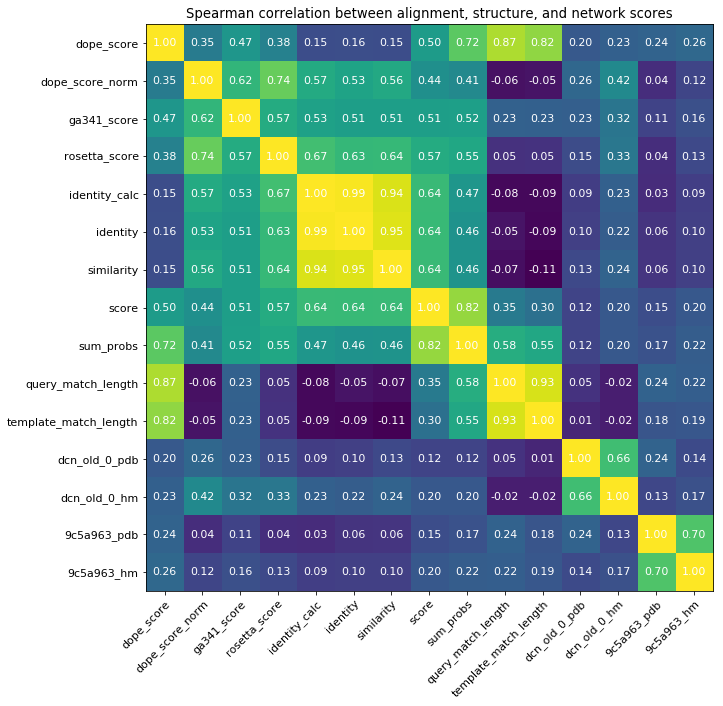

In [76]:
with plt.rc_context(rc={'figure.figsize': (10, 10), 'font.size': 11}):
    plot(results_df, target_columns + feature_columns + network_columns)

plt.tight_layout()
plt.savefig(OUTPUT_PATH.joinpath(f"{NETWORK_NAME}_corr_all.png"), dpi=300, bbox_inches="tight")
plt.savefig(OUTPUT_PATH.joinpath(f"{NETWORK_NAME}_corr_all.pdf"), bbox_inches="tight")

In [77]:
data = []

for query_id, group in results_df.groupby('query_id'):
    assert (group['sequence'].str.replace('-', '') == group['sequence'].iloc[0].replace('-', '')).all()
    assert (group['query_match_length'] == group['query_match_length'].iloc[0]).all()

    if len(group) < 3:
        print(f"Skipping small group for query_id = '{query_id}'")
        continue

    for y_col in target_columns:
        if len(group) < 3 or len(set(group[y_col])) == 1:
            print(f"skipping y_col '{y_col}'")
            continue
        for x_col in feature_columns + network_columns:
            if x_col in ['query_match_length']:
                continue
            if len(group) < 3 or len(set(group[x_col])) == 1:
                print(f"skipping x_col '{x_col}'")
                continue
            corr, pvalue = stats.spearmanr(group[x_col], group[y_col])
            data.append((y_col, x_col, corr, pvalue))
            
correlations_df = pd.DataFrame(data, columns=['target', 'feature', 'correlation', 'pvalue'])

skipping y_col 'ga341_score'
Skipping small group for query_id = '1338580'
Skipping small group for query_id = '1772400'
skipping y_col 'ga341_score'
Skipping small group for query_id = '5540702'
skipping y_col 'ga341_score'
Skipping small group for query_id = '13774339'
Skipping small group for query_id = '14163018'
skipping y_col 'ga341_score'
Skipping small group for query_id = '14613173'
skipping y_col 'ga341_score'
skipping y_col 'ga341_score'
Skipping small group for query_id = '15203185'
skipping y_col 'ga341_score'
skipping x_col 'sum_probs'
skipping x_col 'sum_probs'
skipping y_col 'ga341_score'
skipping x_col 'sum_probs'
skipping x_col 'template_match_length'
skipping x_col 'template_match_length'
skipping y_col 'ga341_score'
skipping x_col 'template_match_length'
Skipping small group for query_id = '20642245'
skipping y_col 'ga341_score'
Skipping small group for query_id = '23847632'
skipping y_col 'ga341_score'
skipping y_col 'ga341_score'
skipping y_col 'ga341_score'
skipp

skipping x_col 'sum_probs'
skipping x_col 'template_match_length'
skipping x_col 'sum_probs'
skipping x_col 'template_match_length'
skipping y_col 'ga341_score'
Skipping small group for query_id = '173169779'
skipping y_col 'ga341_score'
skipping y_col 'ga341_score'
skipping y_col 'ga341_score'
skipping y_col 'ga341_score'
Skipping small group for query_id = '175587075'
Skipping small group for query_id = '176154503'
Skipping small group for query_id = '177065502'
Skipping small group for query_id = '182361517'
skipping y_col 'ga341_score'
Skipping small group for query_id = '182611683'
skipping y_col 'ga341_score'
skipping y_col 'ga341_score'
skipping y_col 'ga341_score'
Skipping small group for query_id = '183523906'
skipping y_col 'ga341_score'
skipping y_col 'ga341_score'
Skipping small group for query_id = '188083845'
Skipping small group for query_id = '191186053'
Skipping small group for query_id = '194434132'
Skipping small group for query_id = '195676885'
Skipping small group 

limit_output extension: Maximum message size of 10000 exceeded with 10241 characters

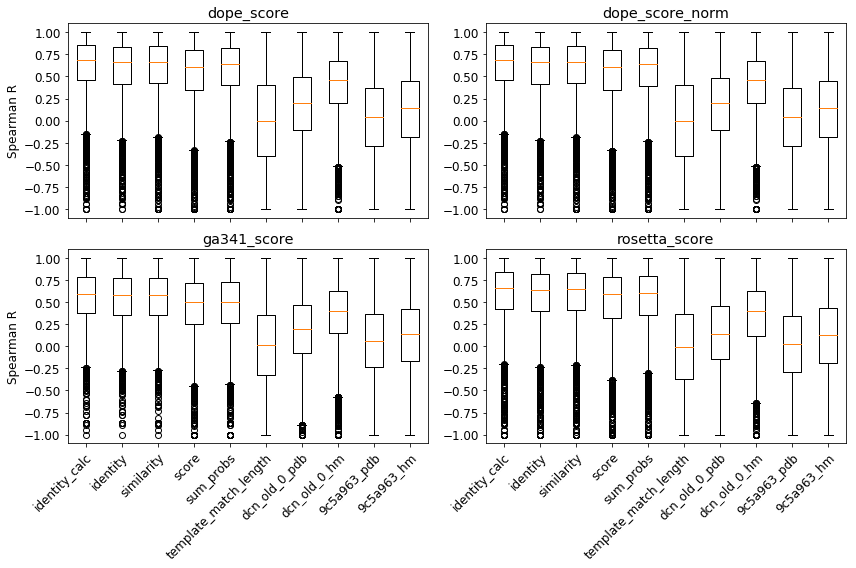

In [78]:
ignore = ['query_match_length']

with plt.rc_context(rc={'figure.figsize': (12, 8), 'font.size': 12}):
    fg, axs = plt.subplots(2, 2)

    for i, target in enumerate(target_columns):
        plt.sca(axs[i // 2, i % 2])

        plt.title(target)

        xticks = [c for c in feature_columns + network_columns if c not in ignore]

        corr = [
            correlations_df[
                (correlations_df['target'] == target) &
                (correlations_df['feature'] == feature)
            ]['correlation'].values
            for feature in xticks
        ]

        plt.boxplot(corr)
        plt.ylim(-1.1, 1.1)

        if i // 2:
            plt.xticks(range(1, len(xticks) + 1), xticks, rotation=45, ha="right", rotation_mode="anchor")
        else:
            plt.xticks(range(1, len(xticks) + 1), [None for _ in xticks])
            
        if i % 2:
#             plt.yticks(plt.yticks()[0], [None for _ in plt.yticks()[0]])
            pass
        else:
            plt.ylabel("Spearman R")
    
plt.tight_layout()
plt.savefig(OUTPUT_PATH.joinpath(f"{NETWORK_NAME}_corr_gby_query.png"), dpi=300, bbox_inches="tight")
plt.savefig(OUTPUT_PATH.joinpath(f"{NETWORK_NAME}_corr_gby_query.pdf"), bbox_inches="tight")